# Configuración Inicial

## Habilitar GPU (Google Colab)

En la barra superior:

1.   Entorno de ejecución
2.   Cambiar tipo de entorno de ejecución -> GPU


## Subir *dataset* (Google Colab)

In [1]:
### QUITAR COMENTARIOS Y EJECUTAR PARA USAR EN GOOGLE COLAB ###

#from google.colab import files

#uploaded = files.upload()  # Seleccionar el archivo desde el sistema local

## Importar utilidades

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2025-03-24 09:41:18.851981: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 09:41:20.152643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742805680.558041   26493 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742805680.669081   26493 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742805681.703775   26493 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# 1 Procesamiento de datos

## 1.1 Carga y exploración inicial

### 1.1.1 Carga del dataset y visualización inicial

In [3]:
df = pd.read_csv('houses_balears.csv')
print("Filas originales:", len(df))

Filas originales: 24880


In [4]:
# Mostrar información básica del DataFrame
print("Filas originales:", len(df))
print("Información del DataFrame:")
print(df.info())

# Convertir columnas numéricas a su tipo apropiado
numeric_columns = ['price', 'm2_real', 'm2_useful', 'bath_num', 'room_num']

# Convertir cada columna numérica
for col in numeric_columns:
    # Identificar valores no numéricos
    non_numeric_mask = ~df[col].astype(str).str.isnumeric()
    non_numeric_count = non_numeric_mask.sum()
    print(f"Valores no numéricos en {col}:", non_numeric_count)
    
    # Convertir a numérico y marcar valores no numéricos como NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Eliminar filas con valores faltantes en price (columna crítica)
df = df.dropna(subset=['price'])
print("\nFilas después de limpiar columnas numéricas:", len(df))

Filas originales: 24880
Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24880 entries, 0 to 24879
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ad_description     24356 non-null  object
 1   ad_last_update     24880 non-null  object
 2   air_conditioner    24880 non-null  object
 3   balcony            24880 non-null  object
 4   bath_num           24880 non-null  object
 5   built_in_wardrobe  24880 non-null  object
 6   chimney            24880 non-null  object
 7   condition          18204 non-null  object
 8   construct_date     10314 non-null  object
 9   energetic_certif   18860 non-null  object
 10  floor              16615 non-null  object
 11  garage             11087 non-null  object
 12  garden             24880 non-null  object
 13  ground_size        58 non-null     object
 14  heating            6349 non-null   object
 15  house_id           24880 non-null  o

In [5]:
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Valores faltantes por columna:
ad_description         524
ad_last_update           0
air_conditioner          0
balcony                  0
bath_num               193
built_in_wardrobe        0
chimney                  0
condition             6676
construct_date       14566
energetic_certif      6020
floor                 8265
garage               13793
garden                   0
ground_size          24822
heating              18531
house_id                 0
house_type               0
kitchen              24822
lift                 14720
loc_city                 0
loc_district          4633
loc_full                 0
loc_neigh            13200
loc_street           21373
loc_zone                 0
m2_real                  0
m2_useful            13176
obtention_date           0
orientation          14001
price                    0
reduced_mobility         0
room_num               379
storage_room             0
swimming_pool            0
terrace                  0
unfurnished          24

In [6]:
columns_to_drop = [
    'ad_description',        # 524 nulos, texto libre (difícil de utilizar)
    'ad_last_update',        # No aporta al modelo
    'built_in_wardrobe',     # No aporta al modelo
    #'condition',            ## 6676 nulos (66% faltante)     PARECE RELEVANTE
    'construct_date',        # 14566 nulos (77% faltante)
    'energetic_certif',      # 6020 nulos (60% faltante)
    #'floor',                ## 8265 nulos (83% faltante)     PARECE RELEVANTE
    'garage',                # 13793 nulos (69% faltante, contiene datos no manejables)
    'ground_size',           # 24822 nulos (100% faltante)
    'heating',               # 18531 nulos (93% faltante)
    'house_id',              # No aporta al modelo
    'house_type',            # No aporta al modelo
    'kitchen',               # 24822 nulos (100% faltante)
    'lift',                  # 14720 nulos (74% faltante)
    'loc_city',              # Contiene datos no manejables
    'loc_district',          # 4633 nulos (46% faltante)
    'loc_full',              # No aporta al modelo
    'loc_neigh',             # 13200 nulos (66% faltante)
    'loc_street',            # 21373 nulos (100% faltante)
    'loc_zone',              # No aporta al modelo
    'm2_useful',             # 13176 nulos (66% faltante, redundante con m2_real)
    'obtention_date',        # No aporta al modelo
    'orientation',           # 14001 nulos (70% faltante)
    'unfurnished'            # 24822 nulos (100% faltante)
]

In [7]:
# Eliminar columnas seleccionadas
df = df.drop(columns=columns_to_drop)

# Verificar resultado
print("\nColumnas restantes:", df.columns.tolist())
print("\nValores faltantes después de limpieza:")
print(df.isnull().sum())


Columnas restantes: ['air_conditioner', 'balcony', 'bath_num', 'chimney', 'condition', 'floor', 'garden', 'm2_real', 'price', 'reduced_mobility', 'room_num', 'storage_room', 'swimming_pool', 'terrace']

Valores faltantes después de limpieza:
air_conditioner        0
balcony                0
bath_num             193
chimney                0
condition           6676
floor               8265
garden                 0
m2_real                0
price                  0
reduced_mobility       0
room_num             379
storage_room           0
swimming_pool          0
terrace                0
dtype: int64


In [8]:
# Verificar los valores nulos por columna antes de tratarlos
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({
    'Valores Nulos': missing_values,
    'Porcentaje (%)': missing_percentage.round(2)
})
print("Resumen de valores faltantes:")
print(missing_summary[missing_summary['Valores Nulos'] > 0].sort_values('Valores Nulos', ascending=False))

Resumen de valores faltantes:
           Valores Nulos  Porcentaje (%)
floor               8265           33.30
condition           6676           26.90
room_num             379            1.53
bath_num             193            0.78


In [9]:
# Tratamiento específico por columna según el tipo y la importancia
# 1. Para columnas categóricas, rellenamos con la categoría más frecuente
categorical_columns = ['condition', 'floor']
for col in categorical_columns:
    most_frequent = df[col].mode()[0]
    df[col] = df[col].fillna(most_frequent)
    print(f"Columna '{col}' rellenada con el valor más frecuente: '{most_frequent}'")

Columna 'condition' rellenada con el valor más frecuente: 'segunda mano/buen estado'
Columna 'floor' rellenada con el valor más frecuente: '2 plantas'


In [10]:
# 2. Para columnas numéricas, rellenamos con la mediana
numeric_cols_with_nulls = ['bath_num', 'room_num']
for col in numeric_cols_with_nulls:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)
    print(f"Columna '{col}' rellenada con la mediana: {median_value}")

Columna 'bath_num' rellenada con la mediana: 2.0
Columna 'room_num' rellenada con la mediana: 3.0


In [11]:
# Verificar que no queden valores nulos
print("\nValores faltantes después del tratamiento:")
print(df.isnull().sum().sum(), "valores nulos en total")

# Verificar la integridad de los datos después del procesamiento
print("\nResumen estadístico de columnas numéricas:")
print(df[['bath_num', 'room_num', 'm2_real', 'price']].describe())


Valores faltantes después del tratamiento:
0 valores nulos en total

Resumen estadístico de columnas numéricas:
           bath_num      room_num        m2_real         price
count  24822.000000  24822.000000   24822.000000  2.482200e+04
mean       2.355733      3.430989    4312.178954  7.594706e+05
std        1.486017      1.723239   30858.977042  1.016877e+06
min        1.000000      1.000000       1.000000  1.000000e+00
25%        1.000000      2.000000     100.000000  2.470000e+05
50%        2.000000      3.000000     180.000000  4.250000e+05
75%        3.000000      4.000000     839.750000  8.400000e+05
max       84.000000     84.000000  900000.000000  2.300000e+07


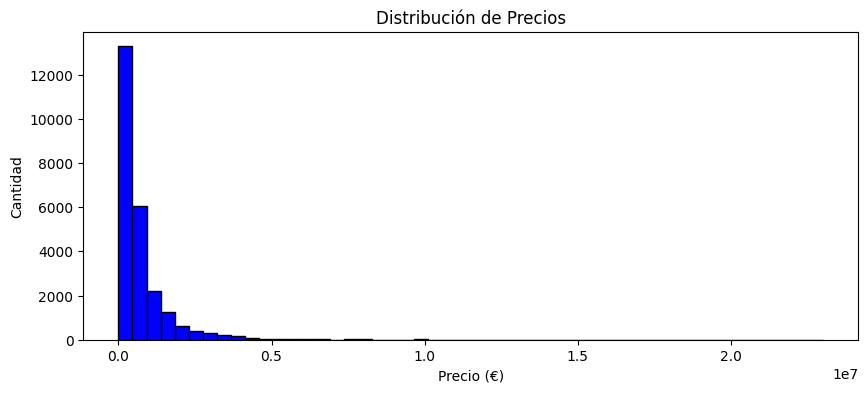

In [12]:
plt.figure(figsize=(10,4))
plt.hist(df['price'], bins=50, color='blue', edgecolor='black')
plt.title('Distribución de Precios')
plt.xlabel('Precio (€)')
plt.ylabel('Cantidad')
plt.show()

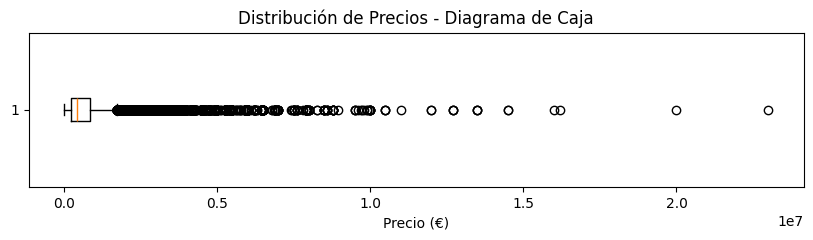

In [13]:
plt.figure(figsize=(10,2))
plt.boxplot(df['price'], vert=False)
plt.title('Distribución de Precios - Diagrama de Caja')
plt.xlabel('Precio (€)')
plt.show()

Límites para outliers de precio: -642500.00 - 1729500.00
Filas antes de eliminar outliers: 24822
Filas después de eliminar outliers: 22527


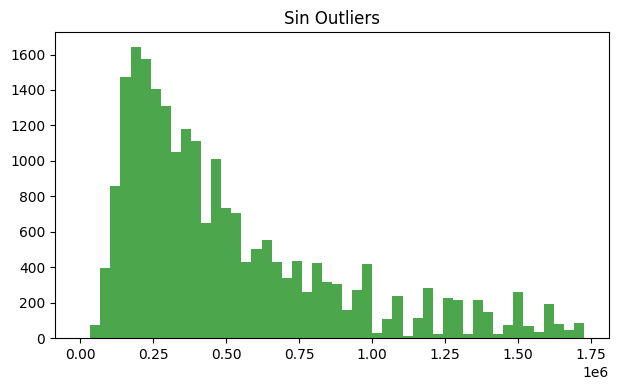

In [14]:
# ---------------------------
# 1. Eliminar outliers de precio
# ---------------------------
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Límites para outliers de precio: {lower_bound:.2f} - {upper_bound:.2f}")
print(f"Filas antes de eliminar outliers: {len(df)}")

df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].copy()
print(f"Filas después de eliminar outliers: {len(df)}")

# Visualización
plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plt.hist(df['price'], bins=50, color='green', alpha=0.7)
plt.title('Sin Outliers')
plt.tight_layout()
plt.show()

In [15]:
# ---------------------------
# 2. Limpiar columna 'floor' (versión corregida)
# ---------------------------
# Extraer números y convertir a float
df['floor'] = df['floor'].str.extract(r'(\d+)', expand=False).astype(float)

# Reemplazar NaN con 0 y convertir a entero
df['floor'] = df['floor'].fillna(0).astype(int)

# Verificación mejorada
unique_floors = df['floor'].unique()
print("\nValores únicos en 'floor':", sorted(unique_floors))
print("Tipo de datos de 'floor':", df['floor'].dtype)
print("Valores nulos restantes:", df['floor'].isnull().sum())


Valores únicos en 'floor': [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(20), np.int64(22), np.int64(46), np.int64(60)]
Tipo de datos de 'floor': int64
Valores nulos restantes: 0


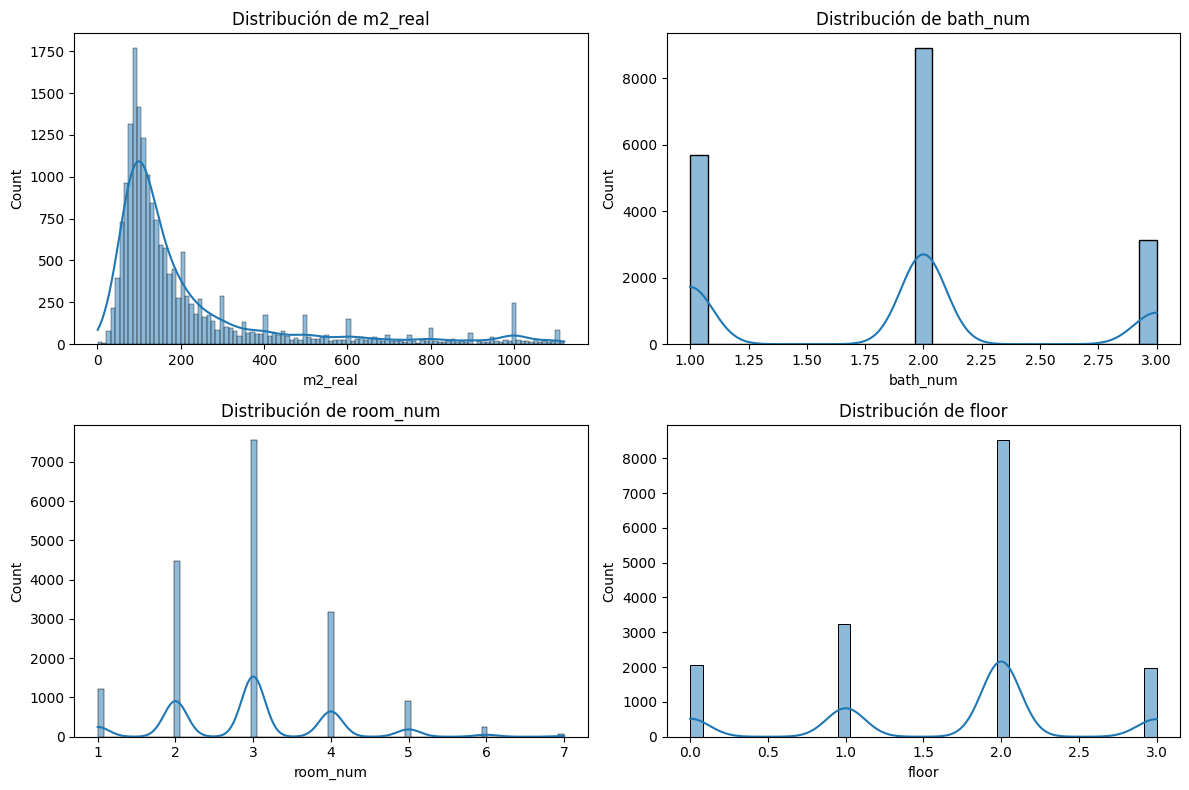

In [16]:
# ---------------------------
# 3. Eliminar outliers en variables numéricas
# ---------------------------
numeric_columns = ['m2_real', 'bath_num', 'room_num', 'floor']

plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_columns, 1):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lb, ub = Q1-1.5*IQR, Q3+1.5*IQR
    
    df = df[(df[col] >= lb) & (df[col] <= ub)]
    
    plt.subplot(2,2,i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')

plt.tight_layout()
plt.show()

In [17]:
# ---------------------------
# 4. Codificación One-Hot
# ---------------------------
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[['condition']])
encoded_df = pd.DataFrame(encoded_features, 
                        columns=['cond_nueva', 'cond_buen_estado', 'cond_reformar'])

In [18]:
# ---------------------------
# 5. Normalización numérica
# ---------------------------
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_columns])
scaled_df = pd.DataFrame(scaled_features, 
                        columns=[f'scaled_{col}' for col in numeric_columns])

In [19]:
# ---------------------------
# 6. Unir transformaciones y limpiar
# ---------------------------
# Mantener solo columnas binarias + transformaciones
df = pd.concat([
    df[['air_conditioner', 'balcony', 'chimney', 'garden', 
       'reduced_mobility', 'storage_room', 'swimming_pool', 'terrace']],
    encoded_df,
    scaled_df,
    df['price']
], axis=1)

print("\nDataset final procesado:")
display(df.head())
print("\nEstructura final:")
print(f"- Variables binarias: {8}")
print(f"- Condiciones codificadas: {3}")
print(f"- Variables escaladas: {len(numeric_columns)}")
print(f"- Total: {df.shape[1]} columnas y {df.shape[0]} filas")


Dataset final procesado:


,air_conditioner,balcony,chimney,garden,reduced_mobility,storage_room,swimming_pool,terrace,cond_nueva,cond_buen_estado,cond_reformar,scaled_m2_real,scaled_bath_num,scaled_room_num,scaled_floor,price
0,1,0,0,1,0,0,1,1,0.0,1.0,0.0,-0.277945,0.184292,-0.912994,1.560585,550000.0
1,1,0,0,0,0,0,0,0,0.0,1.0,0.0,-0.718327,-1.261271,-1.859283,-0.772085,240000.0
3,0,0,0,1,0,0,0,1,0.0,1.0,0.0,-0.277945,0.184292,0.033295,0.394250,300000.0
4,1,1,0,1,0,0,1,1,0.0,1.0,0.0,0.417396,1.629856,3.818450,0.394250,485000.0
6,0,0,0,0,0,0,0,0,0.0,1.0,0.0,-0.050800,0.184292,0.033295,0.394250,1500000.0



Estructura final:
- Variables binarias: 8
- Condiciones codificadas: 3
- Variables escaladas: 4
- Total: 16 columnas y 21457 filas


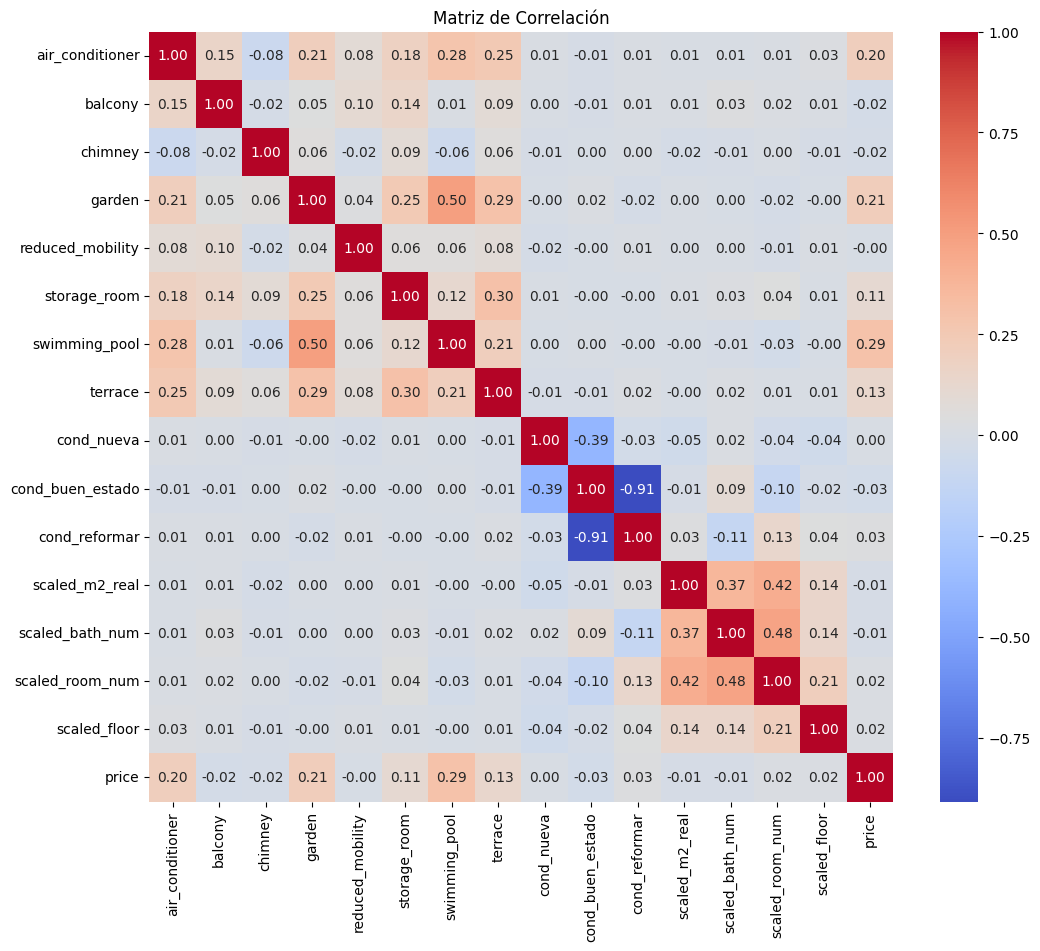

Correlación de las variables con 'price':
swimming_pool       0.294813
garden              0.211191
air_conditioner     0.202551
terrace             0.134927
storage_room        0.111781
cond_reformar       0.033956
scaled_room_num     0.020515
scaled_floor        0.020113
cond_nueva          0.001897
reduced_mobility   -0.003365
scaled_m2_real     -0.008693
scaled_bath_num    -0.012839
chimney            -0.016181
balcony            -0.021786
cond_buen_estado   -0.032166
Name: price, dtype: float64

Variables con alta correlación (|corr| > 0.7) con 'price':
Series([], Name: price, dtype: float64)


In [20]:
# Calcular la matriz de correlación
corr_matrix = df.corr()

# Mostrar el heatmap de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

# Analizar la correlación de cada variable con 'price'
corr_with_price = corr_matrix['price'].drop('price').sort_values(ascending=False)
print("Correlación de las variables con 'price':")
print(corr_with_price)

# Ejemplo de criterio para eliminar variables redundantes:
# Se podría eliminar variables que tengan una correlación absoluta muy alta entre sí (por ejemplo, |corr| > 0.8)
# o aquellas que tengan muy baja correlación con 'price'.
# Aquí se muestra un ejemplo para identificar variables con alta correlación absoluta con 'price':
umbral = 0.7  # umbral para considerar una alta correlación
variables_altamente_correlacionadas = corr_with_price[abs(corr_with_price) > umbral]
print("\nVariables con alta correlación (|corr| > {}) con 'price':".format(umbral))
print(variables_altamente_correlacionadas)

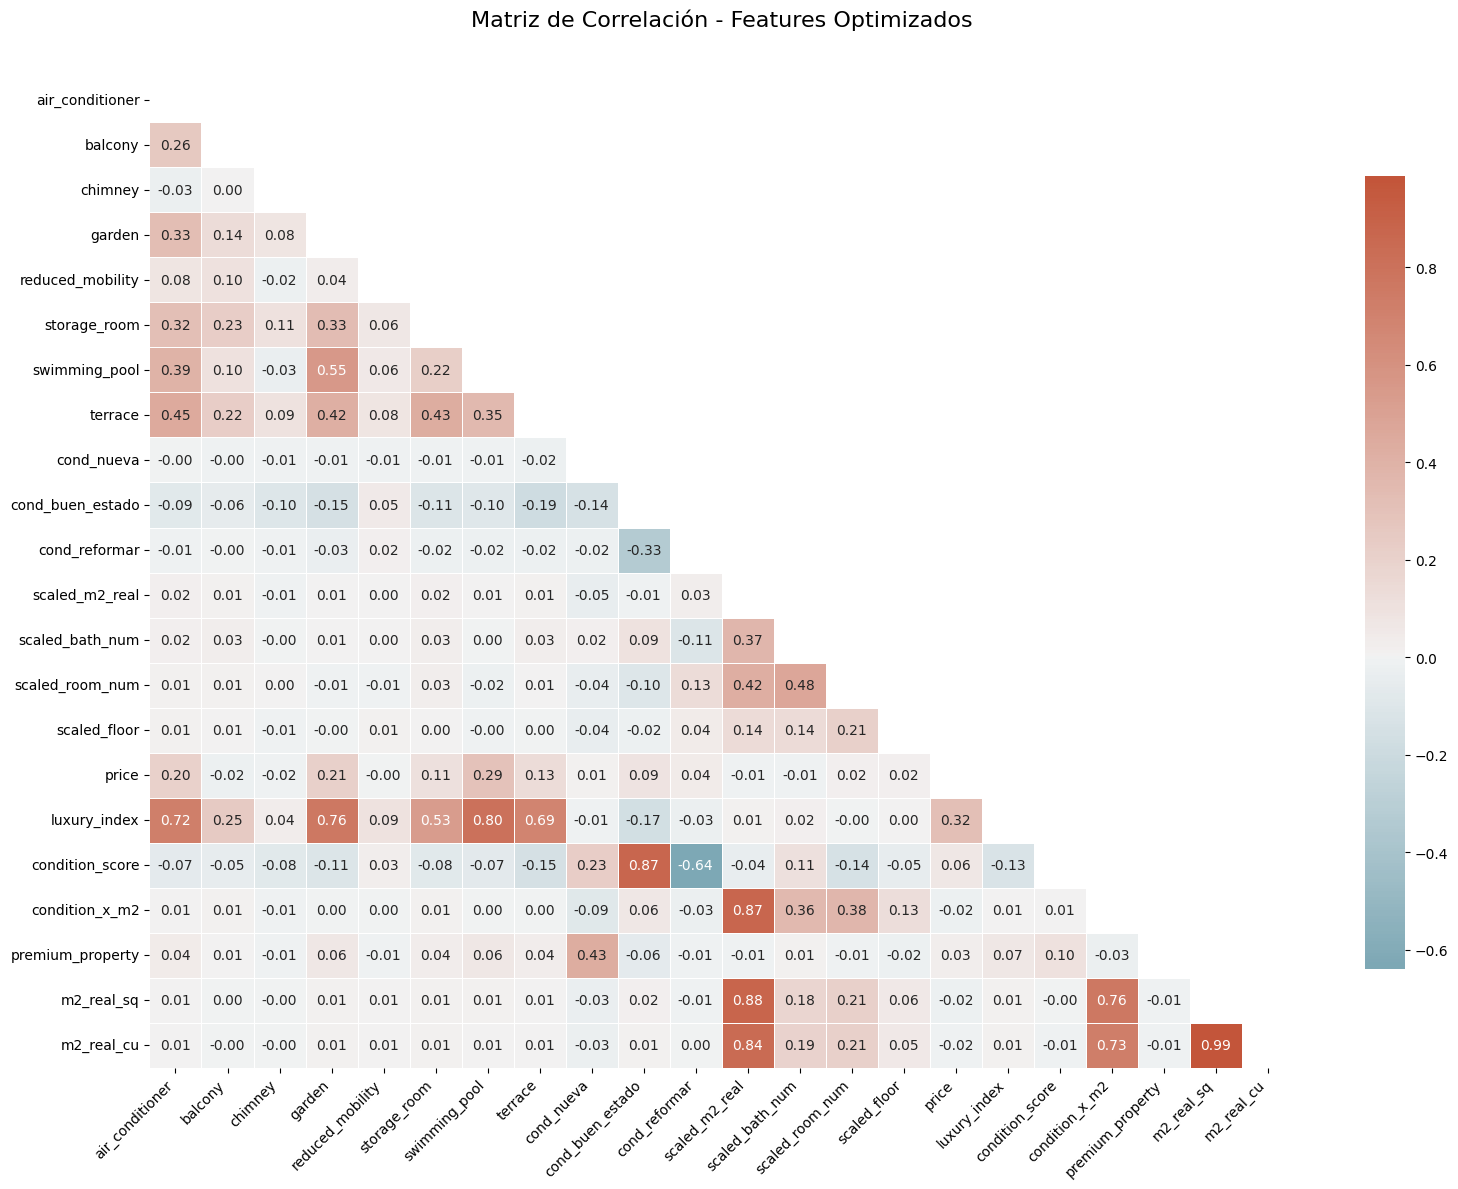


Top 10 Correlaciones con Price:


price               1.000000
luxury_index        0.321318
swimming_pool       0.294813
garden              0.211191
air_conditioner     0.202551
terrace             0.134927
storage_room        0.111781
cond_buen_estado    0.087074
condition_score     0.059714
cond_reformar       0.044964
Name: price, dtype: float64


Features Altamente Correlacionados:


,level_0,level_1,0
1,air_conditioner,luxury_index,0.715967
5,garden,luxury_index,0.760600
9,swimming_pool,luxury_index,0.798952
13,cond_buen_estado,condition_score,0.867799
16,scaled_m2_real,condition_x_m2,0.870737
17,scaled_m2_real,m2_real_sq,0.880219
18,scaled_m2_real,m2_real_cu,0.840715
23,luxury_index,air_conditioner,0.715967
24,luxury_index,garden,0.760600
25,luxury_index,swimming_pool,0.798952



Correlación Nuevos Features con Price:


luxury_index        0.321318
condition_x_m2     -0.018744
premium_property    0.027310
m2_real_sq         -0.019392
Name: price, dtype: float64


Estructura Final del Dataset:
- Registros: 21457
- Variables: 14

Primeras filas:


,scaled_m2_real,scaled_bath_num,scaled_floor,luxury_index,condition_x_m2,premium_property,m2_real_sq,m2_real_cu,cond_nueva,cond_buen_estado,swimming_pool,air_conditioner,terrace,price
0,-0.277945,0.184292,1.560585,0.843482,-0.277945,0,0.077253,-0.021472,0,1,1,1,1,550000.0
1,-0.718327,-1.261271,-0.772085,0.202551,-0.718327,0,0.515994,-0.370653,0,1,0,1,0,240000.0
3,-0.277945,0.184292,0.394250,0.346118,-0.277945,0,0.077253,-0.021472,0,1,0,0,1,300000.0


In [21]:
## 2.2 Análisis de Correlación y Feature Engineering Mejorado

#%% 1. Limpieza y transformación final de datos
# ---------------------------------------------
# Convertir todas las variables binarias a enteros (asegurar consistencia)
binary_cols = ['swimming_pool', 'air_conditioner', 'terrace', 'garden',
               'storage_room', 'balcony', 'chimney', 
               'cond_nueva', 'cond_buen_estado', 'cond_reformar']

df[binary_cols] = df[binary_cols].fillna(0).astype(int)

#%% 2. Feature Engineering Optimizado
# -----------------------------------
# Calcular pesos basados en correlación real
amenity_correlations = df[['swimming_pool', 'air_conditioner', 'terrace', 
                          'garden', 'storage_room']].corrwith(df['price'])

# 2.1 Luxury Index con pesos estadísticos
df['luxury_index'] = df[amenity_correlations.index].mul(amenity_correlations.values).sum(axis=1)

# 2.2 Condition Score mejorado con interacción
df['condition_score'] = (2 * df['cond_nueva'] + df['cond_buen_estado'] - df['cond_reformar'])
df['condition_x_m2'] = df['condition_score'] * df['scaled_m2_real']  # Interacción clave

# 2.3 Variable Premium (combinación estratégica)
luxury_threshold = df['luxury_index'].quantile(0.75)
condition_threshold = df['condition_score'].quantile(0.75)
df['premium_property'] = ((df['luxury_index'] > luxury_threshold) & 
                         (df['condition_score'] > condition_threshold)).astype(int)

# 2.4 Términos no lineales para metros cuadrados
df['m2_real_sq'] = df['scaled_m2_real'] ** 2
df['m2_real_cu'] = df['scaled_m2_real'] ** 3

#%% 3. Análisis de Correlación Mejorado
# -------------------------------------
# Configuración profesional del heatmap
plt.figure(figsize=(16, 12))
corr_matrix = df.corr()

# Máscara y paleta mejoradas
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Heatmap con anotaciones estratégicas
sns.heatmap(corr_matrix, 
            mask=mask,
            cmap=cmap,
            annot=True,
            fmt=".2f",
            center=0,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

# Ajustes de visualización
plt.title("Matriz de Correlación - Features Optimizados\n", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

#%% 4. Análisis de Features Clave
# -------------------------------
# 4.1 Correlaciones con precio ordenadas
price_corr = corr_matrix['price'].sort_values(ascending=False)
print("\nTop 10 Correlaciones con Price:")
display(price_corr.head(10))

# 4.2 Redundancias entre features
high_corr = corr_matrix[corr_matrix.abs() > 0.7].stack().reset_index()
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
print("\nFeatures Altamente Correlacionados:")
display(high_corr)

# 4.3 Validación de nuevos features
new_features = ['luxury_index', 'condition_x_m2', 'premium_property', 'm2_real_sq']
print("\nCorrelación Nuevos Features con Price:")
display(price_corr[new_features])

#%% 5. Exportar Dataset Procesado
# -------------------------------
# Ordenar columnas estratégicamente
final_columns = [
    'scaled_m2_real', 'scaled_bath_num', 'scaled_floor',  # Variables núcleo
    'luxury_index', 'condition_x_m2', 'premium_property',  # Nuevos features
    'm2_real_sq', 'm2_real_cu',                           # Términos no lineales
    'cond_nueva', 'cond_buen_estado',                      # Condiciones relevantes
    'swimming_pool', 'air_conditioner', 'terrace',         # Amenities clave
    'price'                                                # Target
]

df_final = df[final_columns]

print("\nEstructura Final del Dataset:")
print(f"- Registros: {df_final.shape[0]}")
print(f"- Variables: {df_final.shape[1]}")
print("\nPrimeras filas:")
display(df_final.head(3))

# Guardar el DataFrame procesado
df_final.to_csv('houses_balears_final.csv', index=False)

Primeras filas del dataset:
   scaled_m2_real  scaled_bath_num  scaled_floor  luxury_index  \
0       -0.277945         0.184292      1.560585      0.843482   
1       -0.718327        -1.261271     -0.772085      0.202551   
2       -0.277945         0.184292      0.394250      0.346118   
3        0.417396         1.629856      0.394250      0.843482   
4       -0.050800         0.184292      0.394250      0.000000   

   condition_x_m2  premium_property  m2_real_sq  m2_real_cu  cond_nueva  \
0       -0.277945                 0    0.077253   -0.021472           0   
1       -0.718327                 0    0.515994   -0.370653           0   
2       -0.277945                 0    0.077253   -0.021472           0   
3        0.417396                 0    0.174220    0.072719           0   
4       -0.050800                 0    0.002581   -0.000131           0   

   cond_buen_estado  swimming_pool  air_conditioner  terrace      price  
0                 1              1                

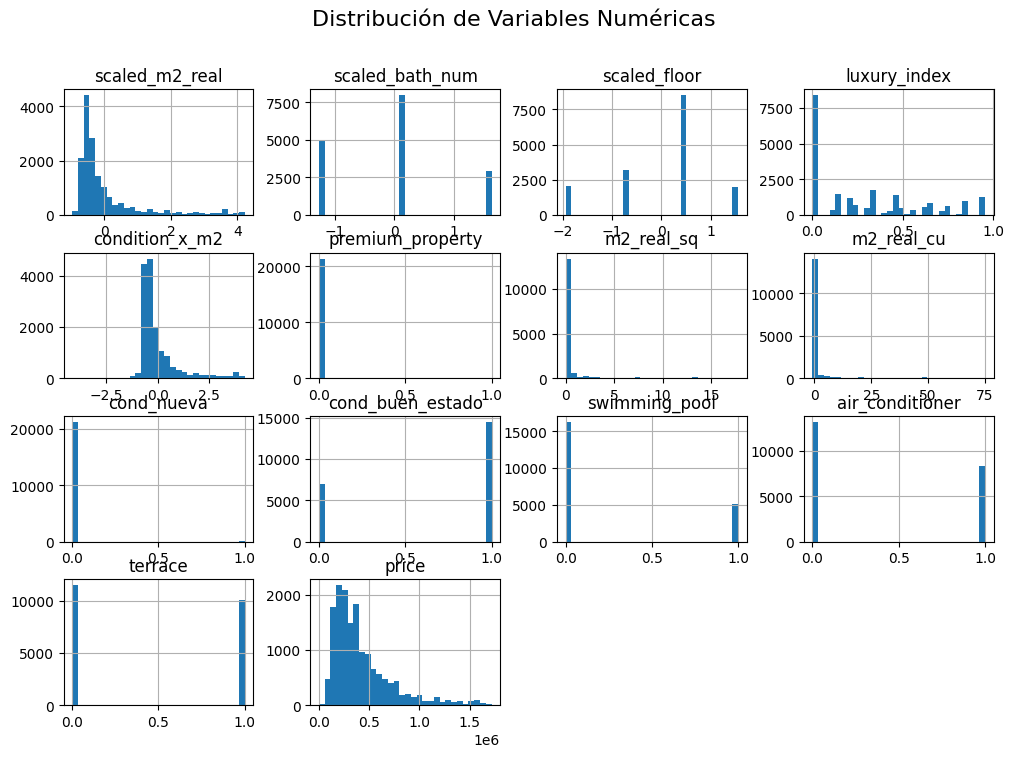

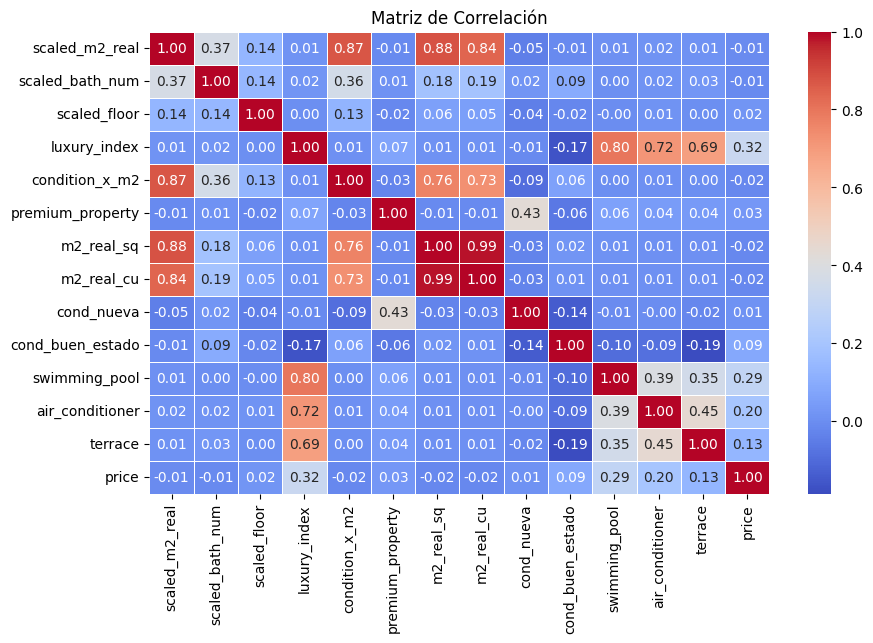

In [22]:
# Cargar el dataset (reemplaza 'dataset.csv' con la ruta de tu archivo)
df = pd.read_csv('houses_balears_final.csv')

# Mostrar las primeras filas
print("Primeras filas del dataset:")
print(df.head())

# Información general del dataset
print("\nInformación general del dataset:")
print(df.info())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df.describe())

# Verificar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Distribución de las variables numéricas
df.hist(figsize=(12, 8), bins=30)
plt.suptitle("Distribución de Variables Numéricas", fontsize=16)
plt.show()

# Matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()
